In [1]:
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn import preprocessing
%matplotlib inline



In [46]:
df = pd.read_csv('BreastCancer.csv', header = None)

In [47]:
# X: 30 features per example (not including index which I excluded)
# Y: diagnosis (M: Malignant, B: Benign) -> map M: 1, B: 0
df.columns = ['index', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 
              'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 
              'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 
              'fractal_dimension_se', 'radius_largest_worst', 'texture_largest_worst', 
              'perimeter_largest_worst', 'area_largest_worst', 'smoothness_largest_worst', 
              'compactness_largest_worst', 'concavity_largest_worst', 'concave_points_largest_worst', 
              'symmetry_largest_worst', 'fractal_dimension_largest_worst']
df = df.drop('index',axis =1)
df = df.sample(frac=1) # shuffle the rows
Y = df['diagnosis']
Y = Y.map({'M': 1, 'B': 0})
df = df.drop('diagnosis', axis=1)
df = (df - df.mean(axis=0))/df.std(axis=0) # feature scaling
df.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_largest_worst,texture_largest_worst,perimeter_largest_worst,area_largest_worst,smoothness_largest_worst,compactness_largest_worst,concavity_largest_worst,concave_points_largest_worst,symmetry_largest_worst,fractal_dimension_largest_worst
125,-0.078686,-0.483523,-0.145234,-0.188083,-0.605105,-0.813837,-0.935769,-0.966660,-0.720860,-0.552041,...,-0.161215,-0.341220,-0.207163,-0.271680,-0.730040,-0.758025,-0.915706,-0.967046,-0.867590,-0.671371
160,-0.674591,0.207009,-0.653074,-0.668030,0.891610,0.184785,-0.255511,-0.297379,0.661631,0.245368,...,-0.610189,0.086683,-0.546126,-0.591339,0.150287,-0.413541,-0.367112,-0.540316,0.431963,-0.225666
352,3.292437,-0.425397,3.384132,3.850686,1.318227,2.498620,3.110904,3.669341,0.526665,-0.224862,...,3.488510,-0.341220,3.631832,4.133464,0.903601,2.157382,1.787479,2.449232,1.275702,0.232773
341,-1.282982,-0.569549,-1.248161,-1.063865,-0.821258,-0.228373,-0.057443,-0.670032,0.818484,1.197161,...,-1.141923,-0.424197,-1.071681,-0.925576,-0.397180,0.555084,0.776091,-0.508216,0.131320,0.791981
287,-0.351099,-1.434456,-0.414792,-0.394952,-1.906288,-1.269598,-0.830400,-0.958928,-1.731282,-0.989696,...,-0.548119,-1.649333,-0.591063,-0.533203,-1.585841,-0.887048,-0.736197,-0.927188,-0.956489,-0.819201


In [36]:
X_train = df.iloc[0:400,:] # first 400 rows
X_cv = df.iloc[400:484,:]
X_test = df.iloc[484:569,:]

Y_train = Y.iloc[0:400]
Y_cv = Y.iloc[400:484]
Y_test = Y.iloc[484:569]

# convert to numpy arrays
# let each column represent one data entry
X_train = X_train.values.T
X_cv = X_cv.values.T
X_test = X_test.values.T
Y_train = Y_train.values.T
Y_cv = Y_cv.values.T
Y_test = Y_test.values.T

Y_train.shape = (1,400)
Y_cv.shape = (1,84)
Y_test.shape = (1,85)

print ("number of training examples = " + str(X_train.shape[1])) 
print ("number of test examples = " + str(X_test.shape[1])) 
print ("X_train shape: " + str(X_train.shape)) 
print ("Y_train shape: " + str(Y_train.shape)) 
print ("X_test shape: " + str(X_test.shape)) 
print ("Y_test shape: " + str(Y_test.shape))
print ("X_cv shape: " + str(X_cv.shape)) 
print ("Y_cv shape: " + str(Y_cv.shape))

number of training examples = 400
number of test examples = 85
X_train shape: (30, 400)
Y_train shape: (1, 400)
X_test shape: (30, 85)
Y_test shape: (1, 85)
X_cv shape: (30, 84)
Y_cv shape: (1, 84)


In [37]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X,Y

def initialize_parameters():
    # input layer      : 30 nodes
    # 1st hidden layer : 20 nodes
    # 2nd hidden layer : 10 nodes
    # output layer     : 1 node
    
    W1 = tf.get_variable('W1', [20,30], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [20,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [10,20], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [10,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3', [1,10], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [1,1], initializer = tf.zeros_initializer())
    
    parameters = {'W1': W1,
                 'b1': b1,
                 'W2': W2,
                 'b2': b2,
                 'W3': W3,
                 'b3': b3}
    return parameters

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)
    
    return Z3

def compute_cost(Z3, Y, parameters):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    
    #L2_regularization_cost = np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))
    
    beta = 0.03
    regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
    cost = tf.reduce_mean(cost + beta*regularizers)
    
    #cost = cost + L2_regularization_cost
    return cost

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [43]:
def model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.001,
         num_epochs = 2000, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3,Y, parameters)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print('Epoch %i cost: %f' % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0 and epoch >= 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs),lw=0.5)
        plt.ylabel('cost')
        plt.xlabel('epoch + 100')
        plt.title('Learning rate='+str(learning_rate))
        
        parameters = sess.run(parameters)
        print('parameters trained')
        
        
        correct_prediction = tf.equal(tf.round(tf.sigmoid(Z3)), tf.round(Y))
        
        """
        # see if there was a type 1 error
        ErrorType1 = tf.placeholder(tf.bool)
        def f1(): return tf.equal(1,2) # no type 1 error
        def f2(): return tf.cond(tf.equal(tf.round(Y), 1), f3, f2) #check if Y=1
        def f3(): return tf.equal(1,1) # type 1 error
        ErrorType1 = tf.cond(correct_prediction, f1, f2)
        
        # see if there was a Type II error
        ErrorType2 = tf.placeholder(tf.bool)
        def f4(): return tf.equal(1,2) # no type 2 error
        def f5(): return tf.cond(tf.equal(tf.round(Y), 0), f6, f5) #check if Y=0
        def f6(): return tf.equal(1,1) # type 2 error
        ErrorType2 = tf.cond(correct_prediction, f4, f5)
        
        
        Type1Error = tf.reduce_mean(tf.cast(ErrorType1, 'float'))
        Type2Error = tf.reduce_mean(tf.cast(ErrorType2, 'float'))
        
        """
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        """
        print("Train T1E:", Type1Error.eval({X: X_train, Y: Y_train}))
        print("Cross_val T1E:", Type1Error.eval({X: X_cv, Y: Y_cv}))
        print("Test T1E:",  Type1Error.eval({X: X_test, Y: Y_test}))
        
        print("Train T2E:", Type2Error.eval({X: X_train, Y: Y_train}))
        print("Cross_val T2E:", Type2Error.eval({X: X_cv, Y: Y_cv}))
        print("Test T2E:",  Type2Error.eval({X: X_test, Y: Y_test}))
        """
        
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Cross_val Accuracy:", accuracy.eval({X: X_cv, Y: Y_cv}))
        print("Test Accuracy:",  accuracy.eval({X: X_test, Y: Y_test}))
        
        
        return parameters
        
                                                                           
        
    

Epoch 0 cost: 1.599091
Epoch 100 cost: 0.506884
Epoch 200 cost: 0.309904
Epoch 300 cost: 0.218844
Epoch 400 cost: 0.195397
Epoch 500 cost: 0.193245
Epoch 600 cost: 0.199414
Epoch 700 cost: 0.190033
Epoch 800 cost: 0.183085
Epoch 900 cost: 0.183371
Epoch 1000 cost: 0.183241
Epoch 1100 cost: 0.180413
Epoch 1200 cost: 0.176373
Epoch 1300 cost: 0.178280
Epoch 1400 cost: 0.180075
Epoch 1500 cost: 0.177163
Epoch 1600 cost: 0.178789
Epoch 1700 cost: 0.176527
Epoch 1800 cost: 0.177951
Epoch 1900 cost: 0.187126
parameters trained
Train Accuracy: 0.9925
Cross_val Accuracy: 0.97619
Test Accuracy: 0.964706


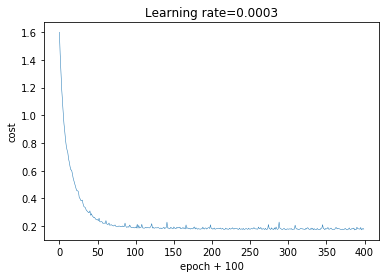

In [44]:
#parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.0001) # blue line
#parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.004)  # orange line
parameters = model(X_train, Y_train, X_test, Y_test, X_cv, Y_cv, learning_rate = 0.0003)   # green line